In [1]:
from timm.models.vision_transformer import VisionTransformer
import torch

/scr/nityakas/gaze_vit_v2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


im gna pass in 3 observations and do a forward pass thru the model to test out my hook. im not expecting anything sensible yet, just want to make sure the shapes work out and that i can actually pull the weights from the last MHA block for regularization. patch_size = 14x14 so 36 patches

In [2]:
data = torch.load('/scr/nityakas/gaze_vit_v2/dataset/Breakout/num_episodes_20_fs4_human.pt', weights_only=False)

obs = data['observations']
actions = data['actions']

In [3]:
env = 'Breakout'
seed = 42
datapath = '../dataset/'
conf_type='normal'
train_type = 'normal'
conf_randomness = 0.0
stack = 1
num_episodes = 2
use_gaze = True
gaze_method = 'Reg'
data_source = 'Our'
gaze_mask_sigma=gaze_mask_sigma = 15.0
gaze_mask_coef=gaze_mask_coeff = 0.7

patch_size = (14, 14)

In [4]:
import sys
sys.path.append('..')

from GABRIL_utils.utils import load_dataset

observations, actions, gaze_masks, gaze_coordinates = load_dataset(
        env=env,
        seed=seed,
        datapath=datapath,
        conf_type=conf_type,
        conf_randomness=conf_randomness,
        stack=stack,
        num_episodes=num_episodes,
        use_gaze=use_gaze,
        data_source=data_source,
        gaze_mask_sigma=gaze_mask_sigma,
        gaze_mask_coef=gaze_mask_coeff                
    )

100%|██████████| 2/2 [00:00<00:00, 157.04it/s]


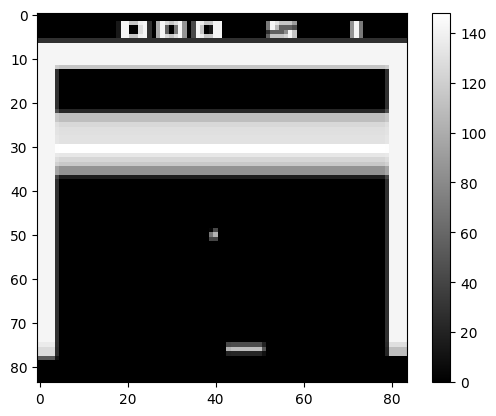

In [5]:
idx = 12

import matplotlib.pyplot as plt

plt.imshow(observations[idx].squeeze().numpy(), cmap='gray')
plt.colorbar()
plt.savefig(f'observation{idx}.jpeg') # GABRIL paper mentions the observations are grayscale
plt.show() 

this shows the values not between 0 and 1 so i still need to normalize. also i got an error screaming that the values werent floats so will need to change the datatype as well

In [6]:
# create a small batch to test with
batch_size = 3
obs_batch = torch.stack([observations[i] for i in range (3)])
obs_batch = obs_batch.float() / 255.0 # change datatype and normalize
actions_batch = torch.stack([actions[i] for i in range (3)])


In [7]:
print(obs_batch.shape)
print(actions.shape)

torch.Size([3, 1, 84, 84])
torch.Size([2198])


the model should output (3, 4): 
- 3 actions, one for each timestep passed in
- 4 possible actions in the action space, one probability for each

Pytorch's CrossEntropyLoss will compare that with the integer scalar labels, so actually it makes perfect sense that actions shape is (23049, ).

In [8]:
patch_size = (14, 14)

In [ ]:
vit = VisionTransformer(patch_size=patch_size) # normal without configs

In [ ]:
from omegaconf import OmegaConf, DictConfig
import os

cfg = OmegaConf.load('/scr/nityakas/gaze_vit_v2/config/vit_s_14_timm.yaml')
vit = VisionTransformer(**cfg) # type: ignore

added `# type: ignore` bc Pylance is being a diva for no reason

In [11]:
out_actions = vit(obs_batch)

In [12]:
print(out_actions.shape)
print(out_actions)

torch.Size([3, 4])
tensor([[-0.2300,  0.0368, -0.4584, -0.4412],
        [-0.2300,  0.0368, -0.4584, -0.4412],
        [-0.2300,  0.0368, -0.4584, -0.4412]], grad_fn=<AddmmBackward0>)


the output is the correct shape woo! the fact that the 4 numbers dont add to 1 is ok because the model outputs logits, not softmaxed probability values. CrossEntropyLoss actually expects this and does its own softmax internally :)

now i gotta write my own hook to extract the attention weights of the last block's MHA layer.

Some fun facts abt hooks:
- The hook function signature is mandatory - it must accept exactly 3 parameters: (layer, input, output). u can call them whatever u want but they're positional args so u cant switch their order

In [ ]:
# prelim hook to test the waters, see what we're dealing with
class AttentionExtractor:
    def __init__(self):
        self.attention_weights = None
    
    def hook_fn(self, layer, input, output):
        # you'll get: torch.Size([3, 37, 1152])
        print("Hook fired!")
        print(input)
        self.attention_weights = output


# print(vit) # wanna see what layers i can attach the hook to

extractor = AttentionExtractor()  
# Register it on a specific layer; Pytorch then calls hook_fn for u automatically when the forward pass happens at that layer(s)
# if u get it right before the attention dropout step, then you'll have QK_t already softmaxed!
handle = vit.blocks[-1].attn.qkv.register_forward_hook(extractor.hook_fn) # type: ignore



In [30]:
# now we test out the hook by running a forward pass
out_actions = vit(obs_batch)
print(extractor.attention_weights.shape)

Hook fired!
(tensor([[[-0.5954,  0.6220, -0.4757,  ..., -1.0155, -1.8307,  0.5318],
         [ 0.1027,  1.3286,  0.1105,  ..., -1.1637, -0.5331,  0.0147],
         [-0.1549,  0.9906, -0.0805,  ..., -1.3575, -0.2268, -0.2154],
         ...,
         [-0.4513,  1.2413, -1.1196,  ..., -0.8788, -1.2253,  0.0408],
         [-0.1624,  0.7801, -1.3848,  ..., -0.6508, -1.9198, -0.0788],
         [ 0.1652,  1.4822, -0.7050,  ..., -0.6291, -1.2569,  0.4267]],

        [[-0.5954,  0.6220, -0.4757,  ..., -1.0155, -1.8307,  0.5318],
         [ 0.1027,  1.3286,  0.1105,  ..., -1.1637, -0.5331,  0.0147],
         [-0.1549,  0.9906, -0.0805,  ..., -1.3575, -0.2268, -0.2154],
         ...,
         [-0.4513,  1.2413, -1.1196,  ..., -0.8788, -1.2253,  0.0408],
         [-0.1624,  0.7801, -1.3848,  ..., -0.6508, -1.9198, -0.0788],
         [ 0.1652,  1.4822, -0.7050,  ..., -0.6291, -1.2569,  0.4267]],

        [[-0.5954,  0.6220, -0.4757,  ..., -1.0155, -1.8307,  0.5318],
         [ 0.1027,  1.3286,  0.1

- 3 = batch
- 37 = num patches + cls token
- 1152 = 384 * 3 because ur getting Q, K, V all concatenated

based on 1040:1031 in pytorch-image-models/timm/models/vision_transformer.py i think CLS token is at index 0

looks like getting out QK_t from the attention block is going to be way gnarlier than i thought, might as well do the matmul + softmax myself. esp if i only care abt the CLS token's attn weights, i just take that out and do the computations

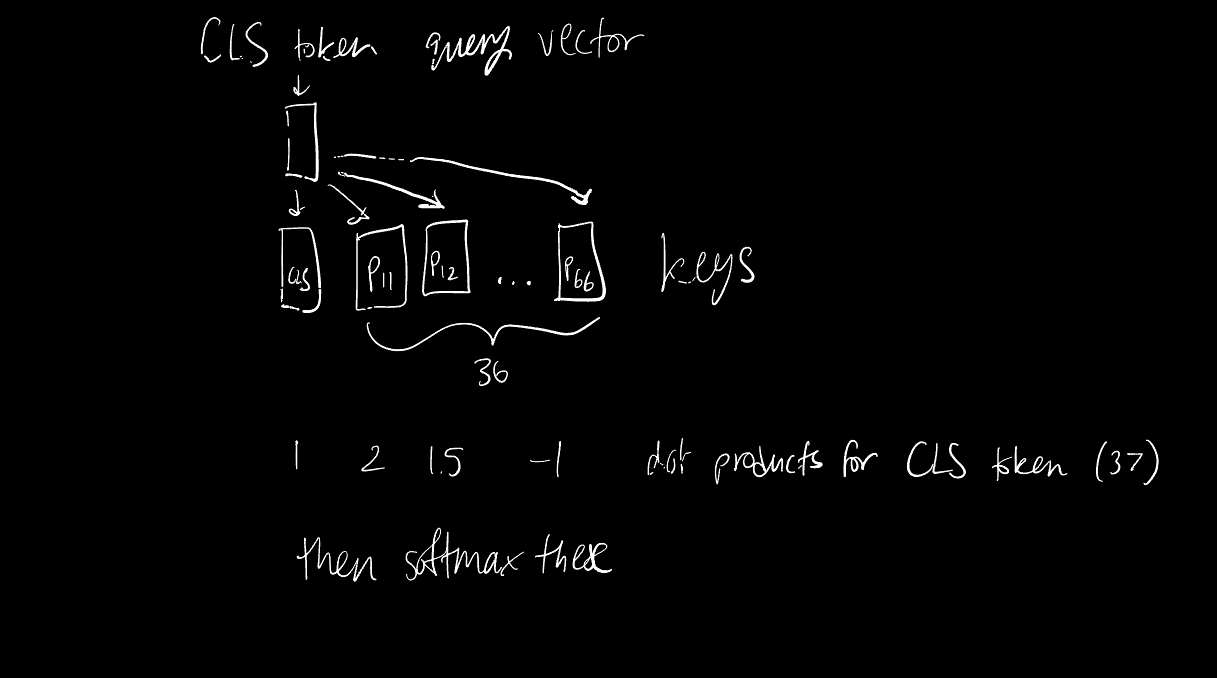

In [55]:
# actual hook
class AttentionExtractor:
    def __init__(self):
        self.attention_weights = None
    
    def hook_fn(self, layer, input, output):
        # separate Q, K, V (technically torch.chunk returns a view not actually splits but whatever)
        Q, K, V = torch.chunk(input, chunks=3, dim=-1) 
        # get out row 0 of Q and K
        q_cls = Q[:, 0, :]
        k_patches = K[:, 1:, :] # exclude CLS token's key (bc we dont care abt its attention to itself)
        print(q_cls.shape)
        print(k_patches.shape)
        print("Hook fired!")
        # print(input)
        self.attention_weights = output


# print(vit) # wanna see what layers i can attach the hook to

extractor = AttentionExtractor()  
# Register it on a specific layer; Pytorch then calls hook_fn for u automatically when the forward pass happens at that layer(s)
# if u get it right before the attention dropout step, then you'll have QK_t already softmaxed!
handle = vit.blocks[-1].attn.register_forward_hook(extractor.hook_fn) # type: ignore


In [56]:
# now we test out the hook by running a forward pass
out_actions = vit(obs_batch)

torch.Size([3, 128])
torch.Size([3, 36, 128])
Hook fired!


torch.Size([3, 128])
torch.Size([3, 36, 128])
Hook fired!
torch.Size([3, 128])
torch.Size([3, 36, 128])
Hook fired!


TypeError: chunk(): argument 'input' (position 1) must be Tensor, not tuple

# Garbage that might become useful later

In [15]:
# versus with Hydra's yaml:
import hydra
from omegaconf import DictConfig

@hydra.main(config_path='/scr/nityakas/gaze_vit_v2/config', config_name='vit_s_14')
def create_vit(cfg: DictConfig):
    return VisionTransformer

vit = create_vit()

/tmp/ipykernel_1722179/4141265395.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='/scr/nityakas/gaze_vit_v2/config', config_name='vit_s_14')
usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/1023/jupyter/runtime/kernel-v3e21f2dad78beb5655b83a7c4

SystemExit: 2

/scr/nityakas/gaze_vit_v2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


decorators (the `@` symbol indicates one) can only be applied to function or class definitions, not variable assignments. Hence we create a function to return the vit with the yaml's specified configs. You'd use the Hydra annotation if u were passing in via command line

In [ ]:
test_tensor12 = torch.tensor([[0.0215, 0.0218, 0.0222, 0.0222, 0.0218, 0.0215, 0.0218, 0.0234, 0.0261,
         0.0262, 0.0235, 0.0218, 0.0226, 0.0276, 0.0376, 0.0382, 0.0282, 0.0227,
         0.0235, 0.0314, 0.0494, 0.0509, 0.0325, 0.0235, 0.0235, 0.0295, 0.0411,
         0.0418, 0.0296, 0.0230, 0.0227, 0.0250, 0.0280, 0.0278, 0.0242, 0.0220]])

In [ ]:
test_tensor2 = torch.tensor([[0.0226, 0.0223, 0.0222, 0.0222, 0.0221, 0.0220, 0.0225, 0.0227, 0.0231,
         0.0233, 0.0228, 0.0222, 0.0236, 0.0248, 0.0258, 0.0255, 0.0239, 0.0225,
         0.0298, 0.0333, 0.0318, 0.0280, 0.0246, 0.0227, 0.0437, 0.0507, 0.0391,
         0.0287, 0.0241, 0.0224, 0.0457, 0.0510, 0.0366, 0.0264, 0.0230, 0.0221]])

In [ ]:
test_tensor20 = torch.tensor([[0.0226, 0.0216, 0.0217, 0.0221, 0.0216, 0.0208, 0.0216, 0.0228, 0.0269,
         0.0299, 0.0268, 0.0228, 0.0217, 0.0261, 0.0381, 0.0466, 0.0363, 0.0257,
         0.0235, 0.0291, 0.0420, 0.0490, 0.0369, 0.0258, 0.0263, 0.0294, 0.0326,
         0.0329, 0.0278, 0.0231, 0.0268, 0.0271, 0.0251, 0.0236, 0.0222, 0.0211]])

In [ ]:
# combine into 1 tensor (b = 3, f = 1, 36)
test_tensor = torch.stack((test_tensor2, test_tensor12, test_tensor20))
test_tensor.shape

torch.Size([3, 1, 36])

In [ ]:
# jax cant work w tensors, need to convert to numpy -> jax array
def convert_to_jax(input_tensor):
    return jnp.asarray(input_tensor.numpy())

Why the NumPy intermediate step?
NumPy arrays are the universal exchange format between Python array libraries. Most frameworks don't have direct conversions to each other, but they all support conversion to/from NumPy.

In [ ]:
test_jax_arr = convert_to_jax(test_tensor)